# Spam or Ham text classifition

## Nataliya Versotskaya

In [1]:
#Firstly, import all necessary 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline 
import nltk
from nltk.corpus import stopwords
import re
import string
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
count_vector = CountVectorizer()
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
df = pd.read_csv('smsspam.csv',usecols = [0,1],encoding='latin-1' )
df.rename(columns = {'v1':'Category','v2': 'Message'}, inplace = True)

In [3]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

This dataset is imbalanced, so we cannot judge the model only by the accuracy score. Even the prediction of all messgees as "ham" messages will give the relatively high results of accuracy. However, it is more important to detect spam messages. So, it is more reasonable to look at the recalls and F1-score, to consider both - positive and negative results.

In [5]:
spam_df = df[df['Category'] == 'spam'] #create sub-dataframe of spam text
ham_df = df[df['Category'] == 'ham'] #sub-dataframe of ham text

In [6]:
stop_words = set(stopwords.words('english'))
def wordCount(text):
    try:
        text = text.lower()
        regex = re.compile('['+re.escape(string.punctuation) + '0-9\\r\\t\\n]') 
        txt = regex.sub(' ',text)  #remove punctuation
        words = [w for w in txt.split(' ')\
                if not w in stop_words and len(w)>3] # remove stop words and words with length smaller than 3 letters
        return len(words)
    except:
        return 0

In [7]:
spam_df['len'] = spam_df['Message'].apply(lambda x: len([w for w in x.split(' ')]))
ham_df['len'] = ham_df['Message'].apply(lambda x: len([w for w in x.split(' ')]))
spam_df['processed_len'] = spam_df['Message'].apply(lambda x: wordCount(x))
ham_df['processed_len'] = ham_df['Message'].apply(lambda x: wordCount(x))

/Users/versockaanatalia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/versockaanatalia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/versockaanatalia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

## Most common words

It is interesting to check whether the most common words are different for spam and ham messages. So, let have a look at 10 most common words for each category.

In [8]:
def tokenize(text):
    exclude = set(string.punctuation)
    regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]') #remove punctuation
    text = regex.sub(' ', text)
    tokens = nltk.word_tokenize(text) # tokenize the text
    tokens = list(filter(lambda x: x.lower() not in stop_words, tokens)) # remove stop words
    tokens = [w.lower() for w in tokens if len(w) >=3] 
    tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
    return tokens

In [9]:
spam_df['tokens'] = spam_df['Message'].map(tokenize)
ham_df['tokens'] = ham_df['Message'].map(tokenize)

/Users/versockaanatalia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/versockaanatalia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
spam_words = []
for token in spam_df['tokens']:
    spam_words = spam_words + token #combine text in different columns in one list
ham_words = []
for token in ham_df['tokens']:
    ham_words += token

In [11]:
spam_count = Counter(spam_words).most_common(10)
ham_count = Counter(ham_words).most_common(10)

In [12]:
spam_count_df = pd.DataFrame(spam_count, columns = ['word', 'count'])
ham_count_df = pd.DataFrame(ham_count, columns = ['word', 'count'])

Text(0.5, 1.0, 'ham top 10 words')

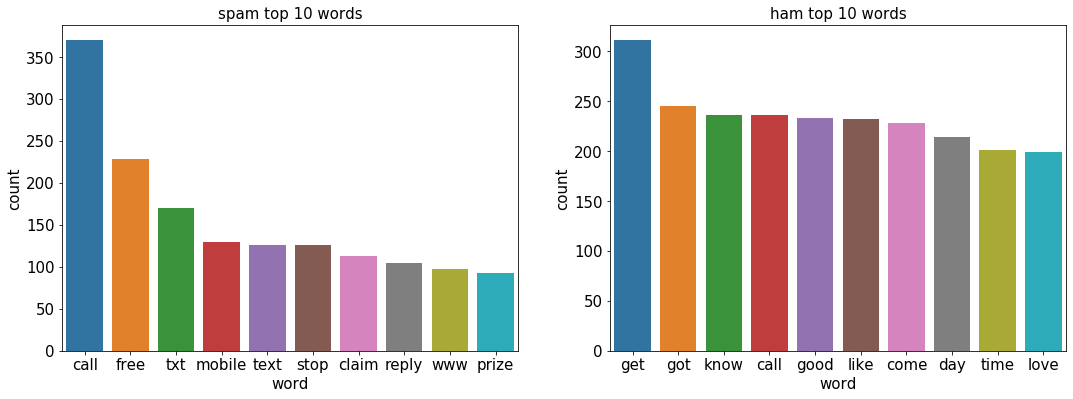

In [13]:
spam_count
fig, (ax,ax1) = plt.subplots(1,2,figsize = (18, 6))
sns.barplot(x = spam_count_df['word'], y = spam_count_df['count'], ax = ax)
ax.set_ylabel('count', fontsize = 15)
ax.set_xlabel('word',fontsize = 15)
ax.tick_params(labelsize=15)
ax.set_title('spam top 10 words', fontsize = 15)
sns.barplot(x = ham_count_df['word'], y = ham_count_df['count'], ax = ax1)
ax1.set_ylabel('count', fontsize = 15)
ax1.set_xlabel('word',fontsize = 15)
ax1.tick_params(labelsize=15)
ax1.set_title('ham top 10 words', fontsize = 15)


So, as we can see, the spam messages have more call-to-action words, such as "call", "reply". In the ham messges ordinary, frequently used words are the most popular. Let visualize these words with Word Clouds.

In [14]:
spam_words_str = ' '.join(spam_words)
ham_words_str = ' '.join(ham_words)

In [15]:
spam_word_cloud = WordCloud(width = 600, height = 400, background_color = 'white').generate(spam_words_str)
ham_word_cloud = WordCloud(width = 600, height = 400,background_color = 'white').generate(ham_words_str)

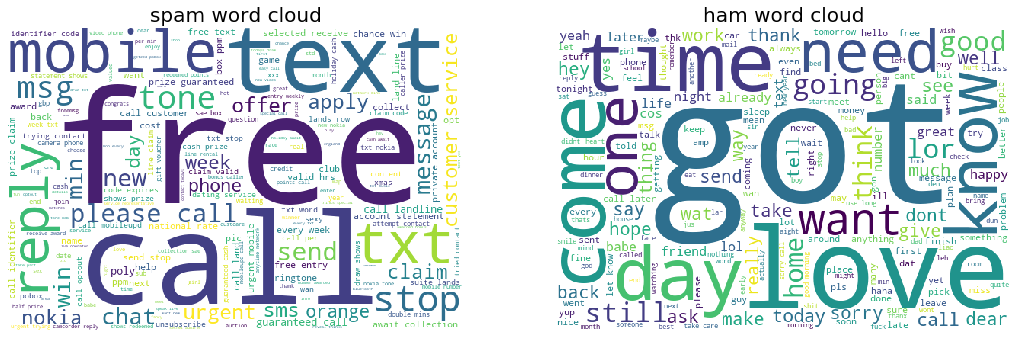

In [16]:
fig, (ax, ax2) = plt.subplots(1,2, figsize = (18,8))
ax.imshow(spam_word_cloud)
ax.axis('off')
ax.set_title('spam word cloud', fontsize = 20)
ax2.imshow(ham_word_cloud)
ax2.axis('off')
ax2.set_title('ham word cloud', fontsize = 20)
plt.show()

## Modelling

**Convert tokens to a matrix of TF-IDF features**

In [17]:
df['tokens'] = df['Message'].map(tokenize)

In [18]:
def text_join(text):
    return " ".join(text)
df['text'] = df['tokens'].apply(text_join)

In [19]:
tv = TfidfVectorizer('english')
features = tv.fit_transform(df['text'])
target = df.Category.map({'ham':0, 'spam':1})

The cross-validation



In [20]:
n_folds = 5
def f1_cv(model):
    kf = KFold(n_folds, shuffle = True, random_state = 29).get_n_splits(features)
    f1 = cross_val_score(model, features, target, scoring = 'f1', cv = kf )
    return (f1)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Base model

Firstly, I used Random Forest and Gradient Boosting Classification models with 5-folds cross validation

In [45]:
rfc = RandomForestClassifier(n_estimators = 31, criterion='gini')
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

In [46]:
rfc_cv_score = cross_val_score(rfc, X_train, y_train, cv=5, scoring= 'roc_auc')

In [47]:
print(classification_report(y_test, rfc_predict))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       1.00      0.83      0.91       150

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [54]:
GBoost = GradientBoostingClassifier(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state =5)
GBoost.fit(X_train,y_train)
# predictions
GBoost_predict = GBoost.predict(X_test)

In [55]:
gb_cv_score = cross_val_score(GBoost, X_train, y_train, cv=5, scoring= 'roc_auc')

In [56]:
print(classification_report(y_test, GBoost_predict))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.85      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



GBoost shows slightly higher results, that Random Forest. The percent of correctly predicted spam messages is higher by 2%

 ## Sklearn Naive Bayer

In [31]:
data = pd.read_csv('smsspam.csv',usecols = [0,1],encoding='latin-1' )
data.rename(columns = {'v1':'Category','v2': 'Message'}, inplace = True)

In [32]:
data.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [33]:
X_train, X_test, y_train, y_test = train_test_split(data['Message'],data['Category'],test_size=0.2)

In [34]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer='word')), # converts strings to integer counts
    ('tfidf',TfidfTransformer()), # converts integer counts to weighted TF-IDF scores
    ('classifier',MultinomialNB()) # train on TF-IDF vectors with Naive Bayes classifier
])

In [35]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [36]:
predictions=pipeline.predict(X_test)

In [37]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.97       959
        spam       1.00      0.65      0.79       156

    accuracy                           0.95      1115
   macro avg       0.97      0.83      0.88      1115
weighted avg       0.95      0.95      0.95      1115



The Gradient Boosting classificator shows higher results that Naive Bayes from Sklearn. Overall accuracy, as well as recalls for spam messages and f1-score is much higher than in Sklearn Naive Bayer